# Data Preparation, Pipelines & Model 

In [1]:
# Modules importeren
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor

from scipy.stats import randint
import joblib
from datetime import datetime

In [2]:
# Dataset importeren 
df = pd.read_csv("/Users/odessa/Desktop/Applied Data Science & AI/Data Science/Code Inleiding data science/song_data.csv")

In [3]:
# Target variabele maken 
target = 'song_popularity'

# Phase 3: Data Preparation

In [4]:
# Alleen 3/4/5 toelaten in de ruwe data
df = df[df['time_signature'].isin([3, 4, 5])]

In [5]:
print(f"Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

# Dubbele waardes droppen van song_name en song_duration 
# Als ik alleen song_name duplicates zou verwijderen, zou ik misschien covers van nummers verwijderen, dus daarom check ik ook de song_duration 
df.drop_duplicates(subset=['song_name', 'song_duration_ms'], inplace = True)
print(f"Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: {len(df)}")

Totaal aantal waardes in de dataframe vóór het verwijderen van dubbele waardes uit song_name en song_duration_ms: 18759
Totaal aantal waardes in de dataframe na verwijderen van dubbele waardes uit song_name en song_duration_ms: 14402


In [6]:
df.drop(columns=["song_name"], inplace=True) # inplace=True veranderd de originele dataframe zonder nieuwe dataframe te maken 

In [7]:
# Laatste twee duplicates verwijderen
df = df.drop_duplicates(keep='first')

In [8]:
# Splitsen van de data in X (features) en y (target)
X = df.drop(columns=[target], axis=1)
y = df[target]

In [9]:
X['key'] = X['key'].astype(int)  # Voor de zekerheid alles naar int 

## Custom Encoders 

### Toonsoort Cyclische Encoder class 

De toonsoort cyclische encoder zet elk getal van 0 t/m 11 om naar een positie op een cirkel, zodat 0 en 11 weer naast elkaar liggen. 

In [10]:
class ToonsoortCyclischeEncoder(BaseEstimator, TransformerMixin):
    """
    Cyclisch encoden van de toonsoort/key (0-11) met sinus en cosinus. 
    """

    def __init__(self, kolom='key', max_waarde=12): # max 12 want key waardes zijn 0 t/m 11 
        self.kolom = kolom
        self.max_waarde = max_waarde
    
    def fit(self, X, y=None): # dit doet niks maar moet voor sklearn 
        return self 
    
    def transform(self, X):
        X = X.copy() # Kopie van X 
        k = X[self.kolom] # pak key kolom 
        X[f'{self.kolom}_sin'] = np.sin(2 * np.pi * k/self.max_waarde) # bereken voor elke key de sinuswaarde -> positie op verticale as van een cirkel
        X[f'{self.kolom}_cos'] = np.cos(2 * np.pi * k/self.max_waarde) # bereken voor elke key de cosinuswaarde -> positie op horizontale as van een cirkel
        return X.drop(columns=[self.kolom]) # verwijder de originele kolom ('key'), want die is nu vervangen
    
    # Geef de namen van de nieuwe features terug
    def get_feature_names_out(self, input_features=None):
        return np.array([f'{self.kolom}_sin', f'{self.kolom}_cos'])

### Outlier Cleaner class

In [11]:
class OutlierCleaner(BaseEstimator, TransformerMixin):
    """Vervangt waarden buiten de grenzen door NaN en vult ontbrekende waarden aan met de kolommediaan."""
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # 1. Outliers in originele numerieke kolommen
        if 'song_duration_ms' in X.columns:
            X.loc[(X['song_duration_ms'] < 30_000) | (X['song_duration_ms'] > 1_200_000), 'song_duration_ms'] = np.nan
        if 'tempo' in X.columns:
            X.loc[(X['tempo'] < 30) | (X['tempo'] > 250), 'tempo'] = np.nan
        if 'loudness' in X.columns:
            X.loc[(X['loudness'] < -60) | (X['loudness'] > 0), 'loudness'] = np.nan

        for col in ['danceability', 'energy', 'audio_valence', 'instrumentalness', 'liveness', 'speechiness']:
            if col in X.columns:
                X.loc[(X[col] < 0) | (X[col] > 1), col] = np.nan

        # 2. Outliers in nieuwe features (indien aanwezig)
        for col in ['valence_dance', 'acoustic_dance_ratio', 'duration_energy_ratio']:
            if col in X.columns:
                onder_grens = X[col].quantile(0.01)
                boven_grens = X[col].quantile(0.99)
                X.loc[(X[col] < onder_grens) | (X[col] > boven_grens), col] = np.nan

        # 3. Controle op maatsoort
        if 'time_signature' in X.columns:
            X.loc[~X['time_signature'].isin([3, 4, 5]), 'time_signature'] = np.nan

        # 4. Vul missende waarden op met medianen
        X.fillna(X.median(numeric_only=True), inplace=True)
        return X

### Nieuwe features functie 

In [13]:
def nieuwe_features(df):
    df = df.copy()
    df['valence_dance'] = df['audio_valence'] * df['danceability']
    
    # Ratio features
    df['acoustic_dance_ratio'] = df['acousticness'] / (df['danceability'] + 0.001) # Kleine constante (0.001) toegevoegd om deling door nul te vermijden als een waarde in een van de kolommen nul is 
    df['duration_energy_ratio'] = df['song_duration_ms'] / (df['energy'] + 0.001) 
    
    return df
feature_engineering = FunctionTransformer(nieuwe_features, validate=False)

# Phase 4: Modeling 

In [14]:
# markdown hieronder later weghalen 

Supervised learning, omdat je de uitkomst al hebt 
<br>
Supervised learning heeft 2 hoofdtakken: regressie en classificatie 
<br>
RMSE 
<br>
Meervoudige lineare regressie 
<br>
Logistieke lineare regressie is classification 
<br>
Random forests is het begin van dat machine learning slim werd

In [15]:
# Train en test set maken 
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state = 42
)

## Preprocessors

In [16]:
# Kolommen definiëren
categorische_kolommen = ['time_signature']
cyclische_kolommen = ['key']

yeo_cols = [
    'danceability', 'audio_valence', 'energy', 'loudness',
    'instrumentalness', 'liveness', 'speechiness',
    'acoustic_dance_ratio', 'duration_energy_ratio'
]

log_cols = ['song_duration_ms']

In [17]:
preprocessor = ColumnTransformer([
    # Log-transformatie
    ('log', Pipeline([
        ('log', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', StandardScaler())
    ]), log_cols),

    # Yeo-Johnson transformatie
    ('yeo', Pipeline([
        ('yeo', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), yeo_cols),

    # One-hot encoding
    ('onehot', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), categorische_kolommen),
    # Cyclische encoding van key
    ('key_cyclisch', Pipeline([
        ('encoder', ToonsoortCyclischeEncoder(kolom='key', max_waarde=12)),
        ('scaler', StandardScaler())
    ]), cyclische_kolommen),

    # Overige numerieke kolommen schalen
    ('scale_rest', StandardScaler(),
     [c for c in X.columns
      if c not in yeo_cols + log_cols + categorische_kolommen + cyclische_kolommen
      and c != 'song_popularity'
     ] + ['valence_dance'])
],
remainder='drop')

## Pipelines

In [ ]:
# Lineaire pipeline 
lineair_pipeline = Pipeline([
    ('feature_creation', feature_engineering),   
    ('clean_outliers', OutlierCleaner()),       
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

In [ ]:
# Random forest pipeline
random_forest_pipeline = Pipeline([
    ('feature_creation', feature_engineering),
    ('clean_outliers', OutlierCleaner()),
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [ ]:
# train en test shape bekijken 
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (11520, 13)
Test shape: (2880, 13)


## Hyperparameter Tuning voor Random Forest Regressor 

### Fase 1: RandomizedSearchCV

In [21]:
# Broad parameter ranges
param_dist = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': randint(4, 16),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=random_forest_pipeline,
    param_distributions=param_dist,
    n_iter=25,          # number of random combinations to test
    scoring='r2',
    cv=3,               # fewer folds = faster
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Best parameters (random search):", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

# (Optional) Save for later
joblib.dump(random_search, "random_search_rf.pkl")

# Store the best params for grid refinement
best = random_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END model__max_depth=14, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=  16.6s
[CV] END model__max_depth=14, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=  16.6s
[CV] END model__max_depth=14, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=120; total time=  17.1s
[CV] END model__max_depth=14, model__min_samples_leaf=3, model__min_samples_split=9, model__n_estimators=199; total time=  27.3s
[CV] END model__max_depth=14, model__min_samples_leaf=3, model__min_samples_split=9, model__n_estimators=199; total time=  28.6s
[CV] END model__max_depth=14, model__min_samples_leaf=3, model__min_samples_split=9, model__n_estimators=199; total time=  29.0s
[CV] END model__max_depth=11, model__min_samples_leaf=4, model__min_samples_split=4, model__n_estimators=249; total time=  30.8s
[CV] END model__max_depth=11, model_

### Fase 2: GridSearchCV 

In [ ]:
# Define a tighter grid around the best RandomizedSearchCV result
param_grid = { 
    'model__n_estimators': [best['model__n_estimators'] - 50,
                            best['model__n_estimators'],
                            best['model__n_estimators'] + 50],
    'model__max_depth': [best['model__max_depth'] - 2,
                         best['model__max_depth'],
                         best['model__max_depth'] + 2],
    'model__min_samples_split': [best['model__min_samples_split'] - 1,
                                 best['model__min_samples_split'],
                                 best['model__min_samples_split'] + 1],
    'model__min_samples_leaf': [best['model__min_samples_leaf'] - 1,
                                best['model__min_samples_leaf'],
                                best['model__min_samples_leaf'] + 1]
}

# Remove invalid (≤ 0) values
for key, vals in param_grid.items():
    param_grid[key] = [v for v in vals if v > 0]

# Define grid search
grid_search = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters (grid refinement):", grid_search.best_params_)
print("Cross-val R²:", grid_search.best_score_)

# Save the trained grid search for later use
joblib.dump(grid_search, "grid_search_rf.pkl")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=343; total time=  29.8s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=343; total time=  30.1s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=343; total time=  30.3s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=343; total time=  30.3s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=343; total time=  30.8s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=9, model__n_estimators=343; total time=  32.9s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__min_samples_split=8, model__n_estimators=393; total time=  34.0s
[CV] END model__max_depth=6, model__min_sa

['grid_search_rf.pkl']

In [23]:
# grid_search = joblib.load("grid_search_rf.pkl") # gebruik als ik niet alles wil re runnen in de notebook. comment randomized search en gridsearch en run dit codeblok 

## Evaluatie van modellen op test data
Drie modellen worden geëvalueerd met 5-fold cross-validatie: 
- Baseline (mean) — voorspelt altijd het gemiddelde.
- Lineaire regressie.
- Random Forest Regressor (met hyperparameter tuning).

De prestatie wordt gemeten met:
- R² (verklaarde variantie)
- RMSE (gemiddelde voorspelfout)

### 1. K-Fold Cross-validation 

In [56]:
# Definieer K-Fold (5 splits)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evalueer Lineaire regressie
scores_lin = cross_val_score(lineair_pipeline, X, y, cv=kfold,
                             scoring=make_scorer(r2_score))

# Evalueer Random Forest 
scores_rf = cross_val_score(random_forest_pipeline, X, y, cv=kfold,
                            scoring=make_scorer(r2_score))

# Custom scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: 
                          root_mean_squared_error(y_true, y_pred),
                          greater_is_better=False)

# Toevoegen RMSE cross-val voor random forest 
scores_rf_rmse = cross_val_score(random_forest_pipeline, X, y, cv=kfold, scoring=rmse_scorer)

# Toevoegen RMSE cross-val voor lineaire regressie
scores_lin_rmse = cross_val_score(lineair_pipeline, X, y, cv=kfold, scoring=rmse_scorer)

In [57]:
# Maak samenvattings-tabel met resultaten per model
resultaten_cv = pd.DataFrame({
    "Model": ["Lineaire Regressie", "Random Forest"],
    "Gem. R²": [np.mean(scores_lin), np.mean(scores_rf)],
    "SD R²": [np.std(scores_lin), np.std(scores_rf)],
    "Gem. RMSE": [-np.mean(scores_lin_rmse), -np.mean(scores_rf_rmse)]
}).round(4)

display(resultaten_cv)

# Toon individuele folds 
folds_df = pd.DataFrame({
    "Fold": range(1, 6),
    "Linear R²": scores_lin,
    "RF R²": scores_rf,
    "Linear RMSE": -scores_lin_rmse,
    "RF RMSE": -scores_rf_rmse
}).round(4)

display(folds_df)

,Model,Gem. R²,SD R²,Gem. RMSE
0,Lineaire Regressie,0.0294,0.0057,19.9764
1,Random Forest,0.0342,0.0128,19.9276


,Fold,Linear R²,RF R²,Linear RMSE,RF RMSE
0,1,0.0291,0.0465,19.7411,19.5630
1,2,0.0248,0.0128,20.1648,20.2883
2,3,0.0308,0.0475,19.7707,19.6000
3,4,0.0393,0.0361,19.9709,20.0045
4,5,0.0232,0.0282,20.2346,20.1824


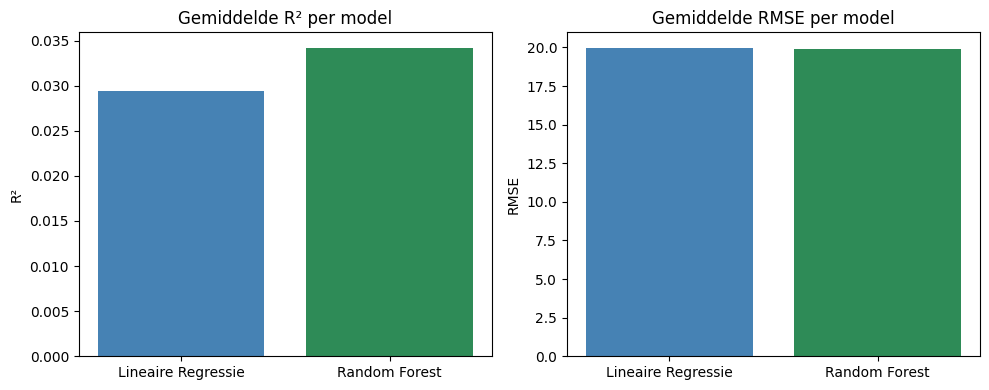

In [58]:
# Plot vergelijking R² en RMSE tussen modellen
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# R² per model
axes[0].bar(resultaten_cv["Model"], resultaten_cv["Gem. R²"], color=["steelblue", "seagreen"])
axes[0].set_title("Gemiddelde R² per model")
axes[0].set_ylabel("R²")

# RMSE per model
axes[1].bar(resultaten_cv["Model"], resultaten_cv["Gem. RMSE"], color=["steelblue", "seagreen"])
axes[1].set_title("Gemiddelde RMSE per model")
axes[1].set_ylabel("RMSE")

plt.tight_layout()
plt.show()

### 2. Testresultaten vergelijken met baseline 

In [59]:
# Baseline (Dummy Regressor)
dummy = DummyRegressor(strategy='mean').fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
r2_dummy = r2_score(y_test, y_pred_dummy)
rmse_dummy = root_mean_squared_error(y_test, y_pred_dummy)

In [60]:
# Lineaire regressie
lineair_pipeline.fit(X_train, y_train)
y_pred_lin = lineair_pipeline.predict(X_test)
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = root_mean_squared_error(y_test, y_pred_lin)

In [61]:
# Random forest (beste model uit gridsearch)
beste_model = grid_search.best_estimator_
y_pred_rf = beste_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

In [62]:
# Samenvatting in tabel 
resultaten = pd.DataFrame({
    'Model': ['Baseline (mean)', 'Lineaire regressie', 'Random Forest'],
    'R²': [r2_dummy, r2_lin, r2_rf],
    'RMSE': [rmse_dummy, rmse_lin, rmse_rf]
}).round({'R²': 4, 'RMSE': 2})

display(resultaten)

,Model,R²,RMSE
0,Baseline (mean),-0.0000,20.03
1,Lineaire regressie,0.0291,19.74
2,Random Forest,0.0670,19.35


### 3. Resultaten opslaan 

In [63]:
# Voeg experimentnaam en datum toe
experiment = "baseline_model"          # naam aanpassen bij veranderingen 
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

resultaten["Versie"] = experiment             # kolom met experimentnaam
resultaten["Datum"] = timestamp               # kolom met datum en tijd

# Sla het bestand op met experimentnaam en timestamp
bestandsnaam = f"model_resultaten_{experiment}_{timestamp}.csv"
resultaten.to_csv(bestandsnaam, index=False)

print(f"Resultaten opgeslagen als: {bestandsnaam}")

Resultaten opgeslagen als: model_resultaten_baseline_model_20251025_1630.csv


### 4. Beste Random Forest parameters + prestaties 

In [64]:
# Samenvatting van beste Random Forest parameters + prestaties
beste_params = grid_search.best_params_

print("\n Beste Random Forest instellingen:")
for k, v in beste_params.items():
    print(f"  {k.replace('model__', ''):<20}: {v}")

print(f"\n Testprestaties Random Forest:")
print(f"  R²   : {r2_rf:.4f}")
print(f"  RMSE : {rmse_rf:.4f}")

# Compact overzicht in tabel
samenvatting = pd.DataFrame({
    "Hyperparameter": [k.replace('model__', '') for k in beste_params.keys()],
    "Waarde": [v for v in beste_params.values()]
})
samenvatting.loc[len(samenvatting)] = ['R² (test)', round(r2_rf, 4)]
samenvatting.loc[len(samenvatting)] = ['RMSE (test)', round(rmse_rf, 4)]

display(samenvatting)


 Beste Random Forest instellingen:
  max_depth           : 8
  min_samples_leaf    : 3
  min_samples_split   : 9
  n_estimators        : 443

 Testprestaties Random Forest:
  R²   : 0.0670
  RMSE : 19.3513


,Hyperparameter,Waarde
0,max_depth,8.0000
1,min_samples_leaf,3.0000
2,min_samples_split,9.0000
3,n_estimators,443.0000
4,R² (test),0.0670
5,RMSE (test),19.3513


### Observaties resultaten 

Random forest presteert beter dan lineare regressie: R² iets omhoog en RMSE iets omlaag. 
<br>
RMSE van 20 is logisch, omdat je populariteit niet alleen op basis van audio features kunt voorspellen. 

## 5. Feature Importances (Random Forest)

In [65]:
# Get feature names functie 

def get_feature_names_from_column_transformer(ct):
    """
    Haalt feature names uit een ColumnTransformer, inclusief nested Pipelines
    en custom transformers. Slaat stappen over die geen namen genereren
    (zoals FunctionTransformer in log-pipeline) en vult daar originele kolomnamen in.
    """
    feature_names = []

    for name, trans, cols in ct.transformers_:
        if trans == 'drop':
            continue

        # Check of het een pipeline is (zoals bij log of yeo)
        if isinstance(trans, Pipeline):
            last_step = trans[-1]
            # Probeer namen uit de laatste stap te halen
            if hasattr(last_step, 'get_feature_names_out'):
                try:
                    names = last_step.get_feature_names_out(cols)
                except Exception:
                    names = cols  # fallback
            else:
                names = cols
            feature_names.extend(names)

        # Als het geen pipeline is maar wel een transformer met namen
        elif hasattr(trans, 'get_feature_names_out'):
            try:
                feature_names.extend(trans.get_feature_names_out(cols))
            except Exception:
                feature_names.extend(cols)
        else:
            feature_names.extend(cols)

    return feature_names

In [66]:
# Feature importances definieren 

model = grid_search.best_estimator_.named_steps['model']
importances = model.feature_importances_
preprocessor = grid_search.best_estimator_.named_steps['preprocess']
feature_names = get_feature_names_from_column_transformer(preprocessor)

⚠️ Aantal feature_importances: 19, aantal feature_names: 18


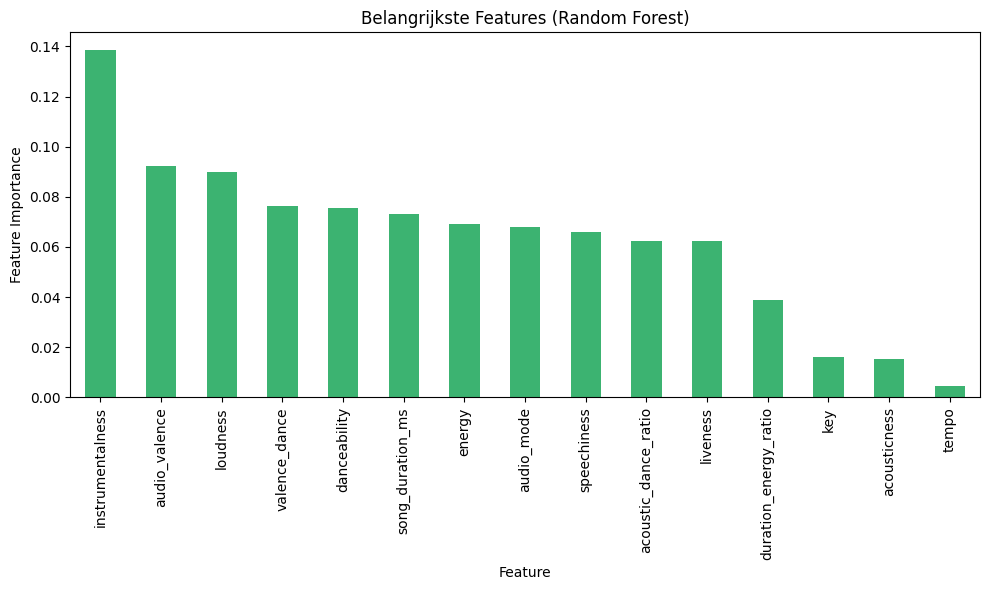

In [67]:
# Veiligheidscheck 
if len(importances) != len(feature_names):
    print(f"⚠️ Aantal feature_importances: {len(importances)}, aantal feature_names: {len(feature_names)}")
    min_len = min(len(importances), len(feature_names))
    importances = importances[:min_len]
    feature_names = feature_names[:min_len]

# Create series and sort 
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top 15 belangrijke features

plt.figure(figsize=(10, 6))
feat_importance.head(15).plot(kind='bar', color='mediumseagreen')
plt.title("Belangrijkste Features (Random Forest)")
plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [68]:
print(feat_importance.to_string())

instrumentalness         0.138652
audio_valence            0.092228
loudness                 0.089781
valence_dance            0.076152
danceability             0.075729
song_duration_ms         0.073232
energy                   0.069047
audio_mode               0.068045
speechiness              0.066101
acoustic_dance_ratio     0.062528
liveness                 0.062248
duration_energy_ratio    0.038839
key                      0.016131
acousticness             0.015481
tempo                    0.004704
time_signature_4.0       0.001667
time_signature_3.0       0.001471
time_signature_5.0       0.001087
